# Transfer learning example
    - Cats vs dogs dataset
    - Pretrained keras models
    

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
import time
from os import listdir, walk
from os.path import isfile, join
import random

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image


# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


print('Tensorflow version: ', tf.__version__)

data_path = '/home/ubuntu/data/training/image/cats_dogs/sample'


/home/ubuntu/anaconda3/envs/tf18/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version:  1.8.0


In [2]:
# Data features
categories=[]
labels={}
for dirname, dirnames, filenames in walk(join(data_path,'trn')):
    # print path to all subdirectories first.
    for i,subdirname in enumerate(dirnames):
        categories += [subdirname]
        labels[i] = subdirname
print('Categories: ', categories)

n_classes = len(categories)
print('Num classes: ', n_classes)


Categories:  ['cat', 'dog']
Num classes:  2


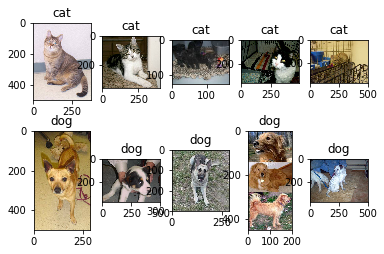

In [3]:
# Examine the images
show_categories = categories
if n_classes>10:
    show_categories = categories[:10]
    
fig = plt.figure()
n=0
for i, category in enumerate(show_categories):
    filelist = [f for f in listdir(join(data_path, 'trn', category)) if isfile(join(data_path, 'trn', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(len(show_categories),5,n)
        a.set_title(category)
        img = plt.imread(join(data_path, 'trn', category, f))
        plt.imshow(img)
    



## Example: evaluate one image using InceptionV3 imagenet trained model.

In [4]:
#Load model
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')


In [5]:
# Lists of image files
my_filelist = [f for f in listdir(join(data_path, 'trn', categories[0])) if isfile(join(data_path, 'trn', categories[0], f))]


Predicted: [('n03325584', 'feather_boa', 0.5999335), ('n02124075', 'Egyptian_cat', 0.048299037), ('n04235860', 'sleeping_bag', 0.030188192)]


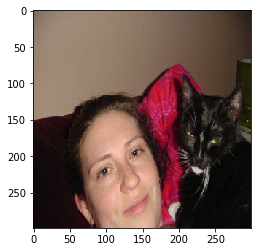

In [6]:
img_path = join(data_path, 'trn', categories[0], my_filelist[500])

# Load image and adapt to inception
def load_image(img_path, draw=True):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    if draw:
        plt.imshow(img)
    return x

x = load_image(img_path)
preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', tf.keras.applications.inception_v3.decode_predictions(preds, top=3)[0])

## Fine tunnig of inceptionV3 for the cats vs dogs problem



In [7]:
#Load base model
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

# Check the output of the last loaded layer
print('Last layer shape:', base_model.output)

Last layer shape: Tensor("mixed10_1/concat:0", shape=(?, 8, 8, 2048), dtype=float32)


In [8]:
# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
print('New last layer shape:', x)

# Add a fully-connected layer
#x = layers.Dense(1024, activation='relu')(x)

# Add the prediction layer. 2 classes
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)



New last layer shape: Tensor("global_average_pooling2d/Mean:0", shape=(?, 2048), dtype=float32)


In [9]:
# Model to train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
# Freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Print the summary of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [10]:
# We preload in memory the original images preprocessed.
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

X_all = []
y_all = []
for i, c in enumerate(categories):
    cat_dir = join(data_path, 'trn', c)
    sample_size_category = len([name for name in os.listdir(cat_dir)])
    print(cat_dir, sample_size_category)
    generator = datagen.flow_from_directory(join(data_path, 'trn'), classes=[c],
                                            target_size=(299, 299), batch_size=sample_size_category)
    X, y = next(generator)
    X = tf.keras.applications.inception_v3.preprocess_input(X)
    X_all += list(X)
    y_all += [i]*len(y)

X_all = np.array(X_all)
y_all = np.array(y_all)

print(X_all.shape, y_all.shape)

/home/ubuntu/data/training/image/cats_dogs/sample/trn/cat 981
Found 981 images belonging to 1 classes.
/home/ubuntu/data/training/image/cats_dogs/sample/trn/dog 981
Found 981 images belonging to 1 classes.
(1962, 299, 299, 3) (1962,)


In [11]:
# Separate train and valid datasets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, train_size=0.7,
                                                      random_state=42)

print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)


/home/ubuntu/anaconda3/envs/tf18/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1373, 299, 299, 3) (589, 299, 299, 3)
(1373,) (589,)


In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)
    


In [13]:
batch_size = 32
train_size = X_train.shape[0]

# Select optimizer and compile model
opt = tf.keras.optimizers.RMSprop(lr=1E-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train
tb_callback_ln = tf.keras.callbacks.TensorBoard(log_dir='/tmp/tensorboard/cats_dogs/inception')

history = model.fit_generator(datagen.flow(X_train, y_train),
        steps_per_epoch = train_size // batch_size,
        epochs = 10,
         validation_data = (X_valid, y_valid),
        callbacks=[tb_callback_ln])


Epoch 1/10
42/42 [==============================] - 38s 894ms/step - loss: 0.4451 - acc: 0.8117 - val_loss: 0.1695 - val_acc: 0.9677
Epoch 2/10
42/42 [==============================] - 34s 799ms/step - loss: 0.2111 - acc: 0.9269 - val_loss: 0.1102 - val_acc: 0.9677
Epoch 3/10
42/42 [==============================] - 33s 791ms/step - loss: 0.1502 - acc: 0.9551 - val_loss: 0.0888 - val_acc: 0.9711
Epoch 4/10
42/42 [==============================] - 33s 788ms/step - loss: 0.1178 - acc: 0.9605 - val_loss: 0.0940 - val_acc: 0.9694
Epoch 5/10
42/42 [==============================] - 33s 782ms/step - loss: 0.1464 - acc: 0.9424 - val_loss: 0.0886 - val_acc: 0.9745
Epoch 6/10
42/42 [==============================] - 32s 768ms/step - loss: 0.0892 - acc: 0.9695 - val_loss: 0.0435 - val_acc: 0.9864
Epoch 7/10
42/42 [==============================] - 32s 765ms/step - loss: 0.0935 - acc: 0.9702 - val_loss: 0.0970 - val_acc: 0.9660
Epoch 8/10
42/42 [==============================] - 32s 756ms/step - 

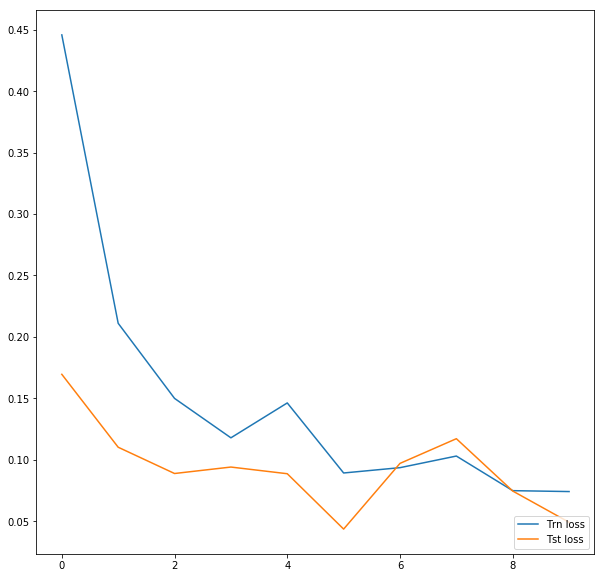

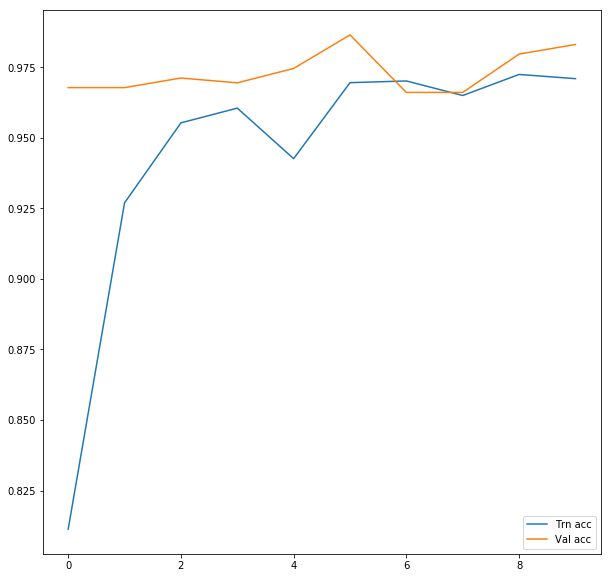

In [14]:
plt.rcParams['figure.figsize'] = (10, 10) 

plt.plot(history.history['loss'], label='Trn loss')
plt.plot(history.history['val_loss'], label='Tst loss')
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['acc'], label='Trn acc')
plt.plot(history.history['val_acc'], label='Val acc')
plt.legend(loc='lower right')
plt.show()



Fists inception cell output shape:  (1, 35, 35, 256)


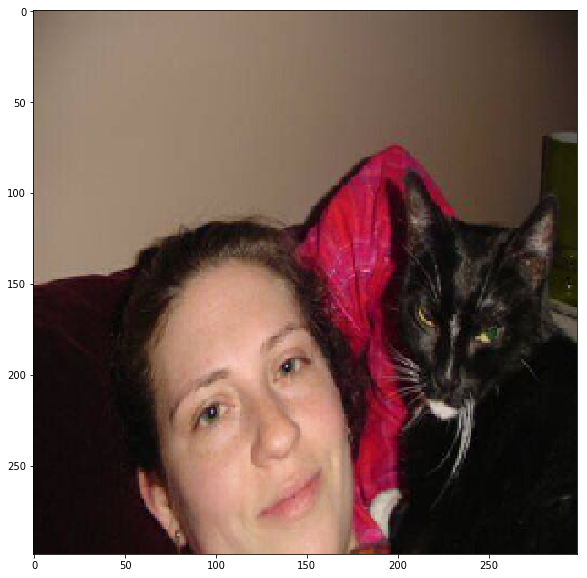

In [15]:
# Print the transformations of the first inception cell: mixed0
model2 = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed0').output)

# Read image img
my_filelist = [f for f in listdir(join(data_path, 'trn', categories[0])) if isfile(join(data_path, 'trn', categories[0], f))]
img_path = join(data_path, 'trn', categories[0], my_filelist[500])
img = load_image(img_path)
x = tf.keras.applications.inception_v3.preprocess_input(img)

mixed0_features = model2.predict(x)

print('Fists inception cell output shape: ', mixed0_features.shape)

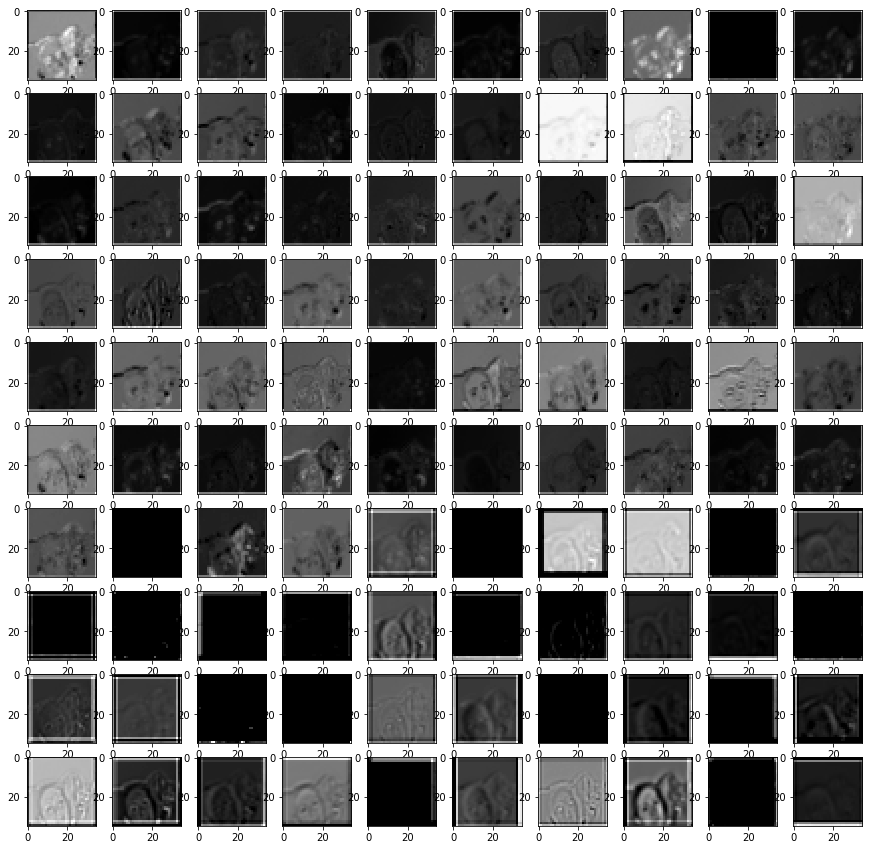

In [16]:
plt.rcParams['figure.figsize'] = (15, 15)        # size of images
plt.rcParams['image.cmap'] = 'gray'              # use grayscale 
fig = plt.figure()
n=0
for i in range(100): #Print the first 100 outputs of the 256.
    n += 1
    a = fig.add_subplot(10,10,n)
    plt.imshow(mixed0_features[0,:,:,i])


In [17]:
#Extract the first convolutional weights
conv2d_1_w = model2.get_layer(base_model.layers[1].name).get_weights()[0]
conv2d_1_w.shape

(3, 3, 3, 32)

# Fine tuning of the last layers
    - We will freeze the bottom N layers and train the remaining top layers.

In [18]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)



0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [19]:
# we chose to train the top 2 inception blocks, i.e. we will freeze from the mixed8 layer
# Then, freeze the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True



In [20]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit_generator(datagen.flow(X_train, y_train),
            steps_per_epoch = train_size // batch_size,
            epochs = 10,
            validation_data = (X_valid, y_valid),
            callbacks=[tb_callback_ln])



Epoch 1/10
42/42 [==============================] - 37s 880ms/step - loss: 0.0847 - acc: 0.9716 - val_loss: 0.0507 - val_acc: 0.9847
Epoch 2/10
42/42 [==============================] - 34s 799ms/step - loss: 0.0621 - acc: 0.9799 - val_loss: 0.0489 - val_acc: 0.9830
Epoch 3/10
42/42 [==============================] - 33s 795ms/step - loss: 0.0663 - acc: 0.9769 - val_loss: 0.0496 - val_acc: 0.9830
Epoch 4/10
42/42 [==============================] - 34s 800ms/step - loss: 0.0630 - acc: 0.9762 - val_loss: 0.0484 - val_acc: 0.9830
Epoch 5/10
42/42 [==============================] - 33s 791ms/step - loss: 0.0581 - acc: 0.9821 - val_loss: 0.0478 - val_acc: 0.9813
Epoch 6/10
42/42 [==============================] - 33s 789ms/step - loss: 0.0557 - acc: 0.9769 - val_loss: 0.0456 - val_acc: 0.9847
Epoch 7/10
42/42 [==============================] - 33s 790ms/step - loss: 0.0464 - acc: 0.9866 - val_loss: 0.0454 - val_acc: 0.9847
Epoch 8/10
42/42 [==============================] - 33s 787ms/step - 

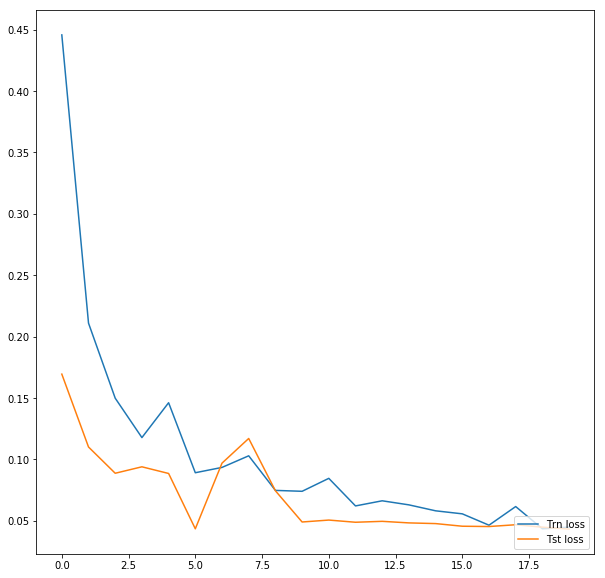

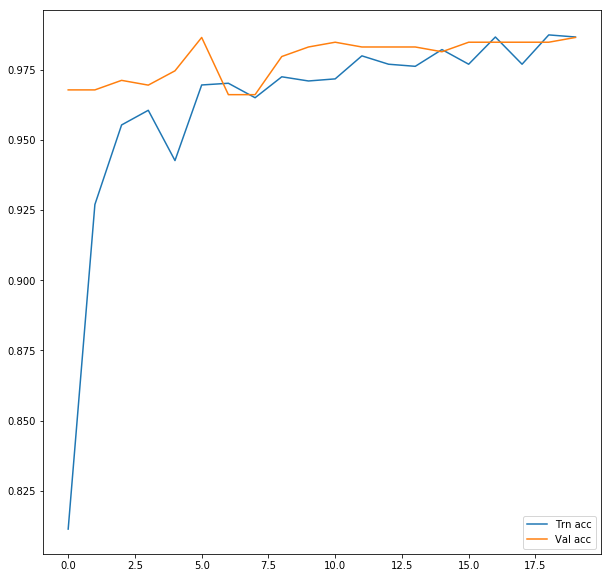

In [21]:
plt.rcParams['figure.figsize'] = (10, 10) 

plt.plot(history.history['loss'] + history2.history['loss'], label='Trn loss')
plt.plot(history.history['val_loss'] + history2.history['val_loss'], label='Tst loss')
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['acc'] + history2.history['acc'], label='Trn acc')
plt.plot(history.history['val_acc'] + history2.history['val_acc'], label='Val acc')
plt.legend(loc='lower right')
plt.show()



## Evaluate the test data

In [19]:
#Read test data into memory

X_tst_raw = []
X_tst = []
y_tst = []

for i, c in enumerate(categories):
    cat_dir = join(data_path, 'tst', c)
    for f in os.listdir(cat_dir):
        img =  tf.keras.preprocessing.image.load_img(join(cat_dir,f), target_size=(299, 299))
        x =  tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X_tst += list( tf.keras.applications.inception_v3.preprocess_input(x))
        X_tst_raw += [img]
        y_tst += [i]

X_tst = np.array(X_tst)
y_tst = np.array(y_tst)
    
print(X_tst.shape, y_tst.shape)


(4022, 299, 299, 3) (4022,)


In [20]:
# Score
probability_test = model.predict(X_tst)
probability_test.shape


(4022, 2)

In [22]:
# Predict
clasify_test = np.argmax(probability_test, axis=1)
prob_clasify = [probability_test[i,clasify_test[i]] for i in range(len(clasify_test))]
clasify_test.shape

(4022,)

Pct errors test:  0.021133764296369966


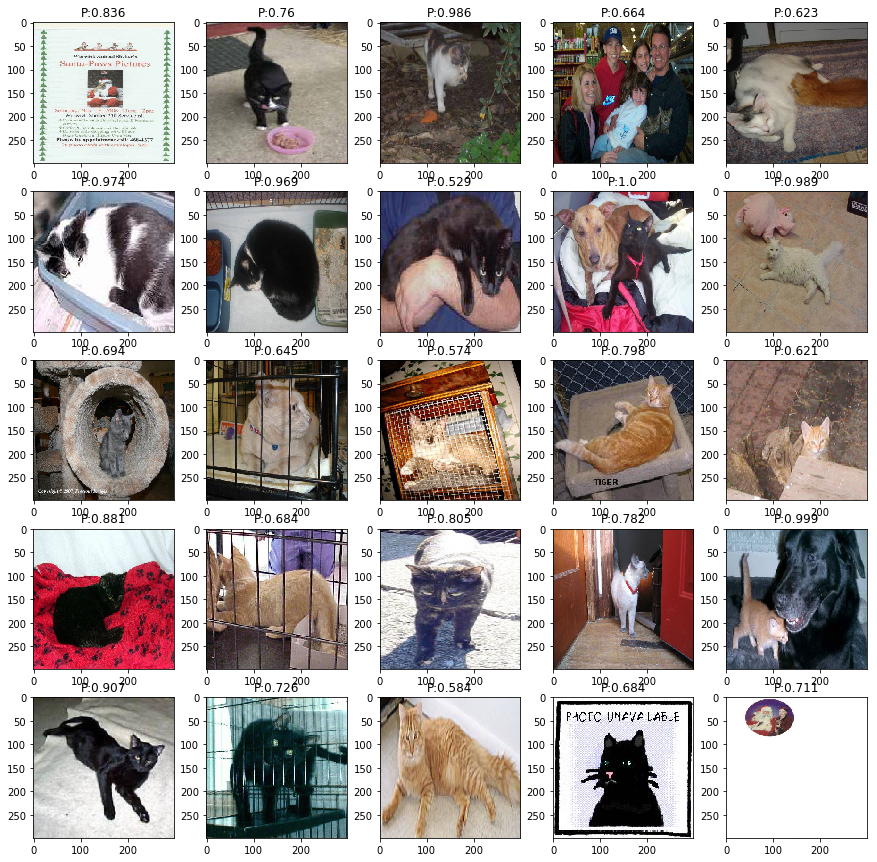

In [24]:
# Print errors
errors_index=[]
for i in range(len(y_tst)):
    if y_tst[i] != clasify_test[i]:
        errors_index += [i]
    
print('Pct errors test: ', len(errors_index)/len(y_tst))

fig = plt.figure()
n=0
for i in errors_index[-25:]: 
    n += 1
    a = fig.add_subplot(5, 5, n)
    a.set_title('P:' + str(round(prob_clasify[i],3)))
    plt.imshow(X_tst_raw[i])
